# Cell/particle Counting and scoring stained objects

This notebook demonstrates how to process plates associated to the paper ['Integration of biological data by kernels on graph nodes allows prediction of new genes involved in mitotic chromosome condensation.'](http://dx.doi.org/10.1091/mbc.E13-04-0221) using [CellProfiler](http://cellprofiler.org/).
We use the example pipeline [Cell/particle counting, and scoring the percentage of stained objects](http://cellprofiler.org/examples/#PercentPositive). This pipeline is for two-channel images.
Metadata are loaded from IDR and binary data from S3

### Import Packages

In [1]:
# %tb

# Import Cell Profiler Dependencies
import cellprofiler
import cellprofiler.preferences as cpprefs
import cellprofiler.module as cpm
import cellprofiler.pipeline as cpp
cpprefs.set_headless()

# Inject Image module used to inject OMERO image planes into Cell Profiler Pipeline
from cellprofiler.modules.injectimage import InjectImage

# Import OMERO Python BlitzGateway
import omero
from omero.gateway import BlitzGateway

# Import Numpy
import numpy as np

# Import Python System Packages
import os
import tempfile
import pandas
import warnings

import zarr
import s3fs
import dask.array as da

# Import Matplotlib
import matplotlib
import matplotlib.pyplot as plt

/srv/conda/envs/kernel/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Set Cell Output Directory

In [2]:
new_output_directory = os.path.normcase(tempfile.mkdtemp())
cpprefs.set_default_output_directory(new_output_directory)

### Connect to IDR

In [3]:
conn = BlitzGateway(host='ws://idr.openmicroscopy.org/omero-ws', username='public', passwd='public', secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

### Fetch from IDR the Plate that contains the Images to be analysed

In [4]:
plate_id = 422
plate = conn.getObject("Plate", plate_id)
print('Plate Name: ', plate.getName())

('Plate Name: ', 'plate1_1_013')


In [5]:
# Load pipeline and inspect modules
from os.path import expanduser
home = expanduser("~")
pipeline = cpp.Pipeline()
pipeline.load(home+"/notebooks/pipelines/ExamplePercentPositive.cppipe")

# Remove first 4 modules: Images, Metadata, NamesAndTypes, Groups...
# (replaced by InjectImage module below)
for i in range(4):
    print('Remove module: ', pipeline.modules()[0].module_name)
    pipeline.remove_module(1)

print('Pipeline modules:')
for module in pipeline.modules():
    print(module.module_num, module.module_name)

('Remove module: ', 'Images')
('Remove module: ', 'Metadata')
('Remove module: ', 'NamesAndTypes')
('Remove module: ', 'Groups')
Pipeline modules:
(1, 'IdentifyPrimaryObjects')
(2, 'IdentifyPrimaryObjects')
(3, 'RelateObjects')
(4, 'FilterObjects')
(5, 'MeasureObjectIntensity')
(6, 'OverlayOutlines')
(7, 'DisplayDataOnImage')
(8, 'ClassifyObjects')
(9, 'CalculateMath')
(10, 'ExportToSpreadsheet')


### Load dask array from S3

In [6]:
def load_dask_array_from_s3(index, resolution='0'):
    cache_size_mb = 2048
    # ID to be changed
    cfg = {
        'anon': True,
        'client_kwargs': {
            'endpoint_url': 'https://minio-dev.openmicroscopy.org/',
        },
        'root': 'idr/zarr/v0.1-extra/plate-%s.zarr/%s/%s' % (plate_id, index, resolution)
    }
    s3 = s3fs.S3FileSystem(
        anon=cfg['anon'],
        client_kwargs=cfg['client_kwargs'],
    )
    print(cfg['root'])
    store = s3fs.S3Map(root=cfg['root'], s3=s3, check=False)
    cached_store = zarr.LRUStoreCache(store, max_size=(cache_size_mb * 2**20))
    # data.shape is (t, c, z, y, x) by convention
    return da.from_zarr(cached_store)

### Run Cell Profiler Pipeline on the plate

In [8]:
warnings.filterwarnings('ignore')

Nuclei = pandas.DataFrame()
files = list()

# create list from generator
wells = list(plate.listChildren())
# use the first 5 wells only
wells = wells[0:5]
well_count = len(wells)

for count, well in enumerate(wells):
    print('Well: %s/%s' % (count + 1, well_count), 'row:', well.row, 'column:', well.column)
    # Load a single Image per Well
    image = well.getImage(0)
    %time data = load_dask_array_from_s3((well.row+1)*(well.column+1)-1)
    size_c = image.getSizeC()

    # For each Image in OMERO, we copy pipeline and inject image modules
    pipeline_copy = pipeline.copy()

    # Inject image for each Channel (pipeline only handles 2 channels)
    for c in range(0, size_c):

        %time plane = data[0, c, 0, :, :]
        image_name = image.getName()

        # Name of the channel expected in the pipeline
        if c == 0:
            image_name = 'OrigBlue'
        if c == 1:
            image_name = 'OrigGreen'

        inject_image_module = InjectImage(image_name, plane)
        inject_image_module.set_module_num(1)
        pipeline_copy.add_module(inject_image_module)

    m = pipeline_copy.run()

    # Results obtained as CSV from Cell Profiler
    path = new_output_directory + '/Nuclei.csv'
    f = pandas.read_csv(path, index_col=None, header=0)
    f['Image'] = image.getId()
    f['Well'] = well.getId()
    f['Cell_Count'] = len(f.index)
    files.append(f)

Nuclei = pandas.concat(files, ignore_index=True)

('Well: 1/5', 'row:', 7L, 'column:', 3L)
idr/zarr/v0.1-extra/plate-422.zarr/31/0
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 427 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 502 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 840 µs
('Well: 2/5', 'row:', 6L, 'column:', 9L)
idr/zarr/v0.1-extra/plate-422.zarr/69/0
CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 210 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 534 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.22 ms
('Well: 3/5', 'row:', 0L, 'column:', 7L)
idr/zarr/v0.1-extra/plate-422.zarr/7/0
CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 221 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 462 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 691 µs
('Well: 4/5', 'row:', 1L, 'column:', 6L)
idr/zarr/v0.1-extra/plate-422.zarr/13/0
CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 220 ms
CPU times: user 0 ns, sys: 0 ns, total

### Calculate statistics

In [9]:
Nuclei.describe()

,ImageNumber,ObjectNumber,Children_PH3PosNuclei_Count,Children_PH3_Count,Classify_PH3Neg,Classify_PH3Pos,Intensity_IntegratedIntensityEdge_OrigBlue,Intensity_IntegratedIntensityEdge_OrigGreen,Intensity_IntegratedIntensity_OrigBlue,Intensity_IntegratedIntensity_OrigGreen,...,Location_MaxIntensity_X_OrigBlue,Location_MaxIntensity_X_OrigGreen,Location_MaxIntensity_Y_OrigBlue,Location_MaxIntensity_Y_OrigGreen,Location_MaxIntensity_Z_OrigBlue,Location_MaxIntensity_Z_OrigGreen,Number_Object_Number,Image,Well,Cell_Count
count,138.0,138.000000,138.000000,138.000000,138.0,138.0,138.000000,138.000000,138.000000,138.000000,...,138.000000,138.000000,138.000000,138.000000,138.0,138.0,138.000000,138.000000,138.000000,138.000000
mean,1.0,16.579710,0.007246,0.007246,1.0,0.0,1.043788,2.283259,30.075852,35.171499,...,697.000000,695.521739,499.847826,500.362319,0.0,0.0,16.579710,179727.702899,67097.702899,32.159420
std,0.0,11.064385,0.085126,0.085126,0.0,0.0,0.182046,0.707093,9.969536,13.734567,...,359.054395,359.267954,293.605150,293.177257,0.0,0.0,11.064385,22.432839,22.432839,10.347429
min,1.0,1.000000,0.000000,0.000000,1.0,0.0,0.195300,0.170169,0.746670,0.499840,...,43.000000,43.000000,21.000000,25.000000,0.0,0.0,1.000000,179708.000000,67078.000000,14.000000
25%,1.0,7.250000,0.000000,0.000000,1.0,0.0,0.935180,1.815183,23.388071,25.932033,...,399.250000,387.250000,222.000000,224.000000,0.0,0.0,7.250000,179708.000000,67078.000000,29.000000
50%,1.0,14.000000,0.000000,0.000000,1.0,0.0,1.047883,2.365934,29.049371,35.072565,...,712.500000,711.000000,508.500000,511.000000,0.0,0.0,14.000000,179720.000000,67090.000000,36.000000
75%,1.0,25.000000,0.000000,0.000000,1.0,0.0,1.162524,2.816308,36.566892,45.873484,...,984.000000,990.250000,743.000000,762.750000,0.0,0.0,25.000000,179729.000000,67099.000000,43.000000
max,1.0,43.000000,1.000000,1.000000,1.0,0.0,1.418586,3.830228,57.049028,65.927962,...,1316.000000,1316.000000,990.000000,1005.000000,0.0,0.0,43.000000,179769.000000,67139.000000,43.000000


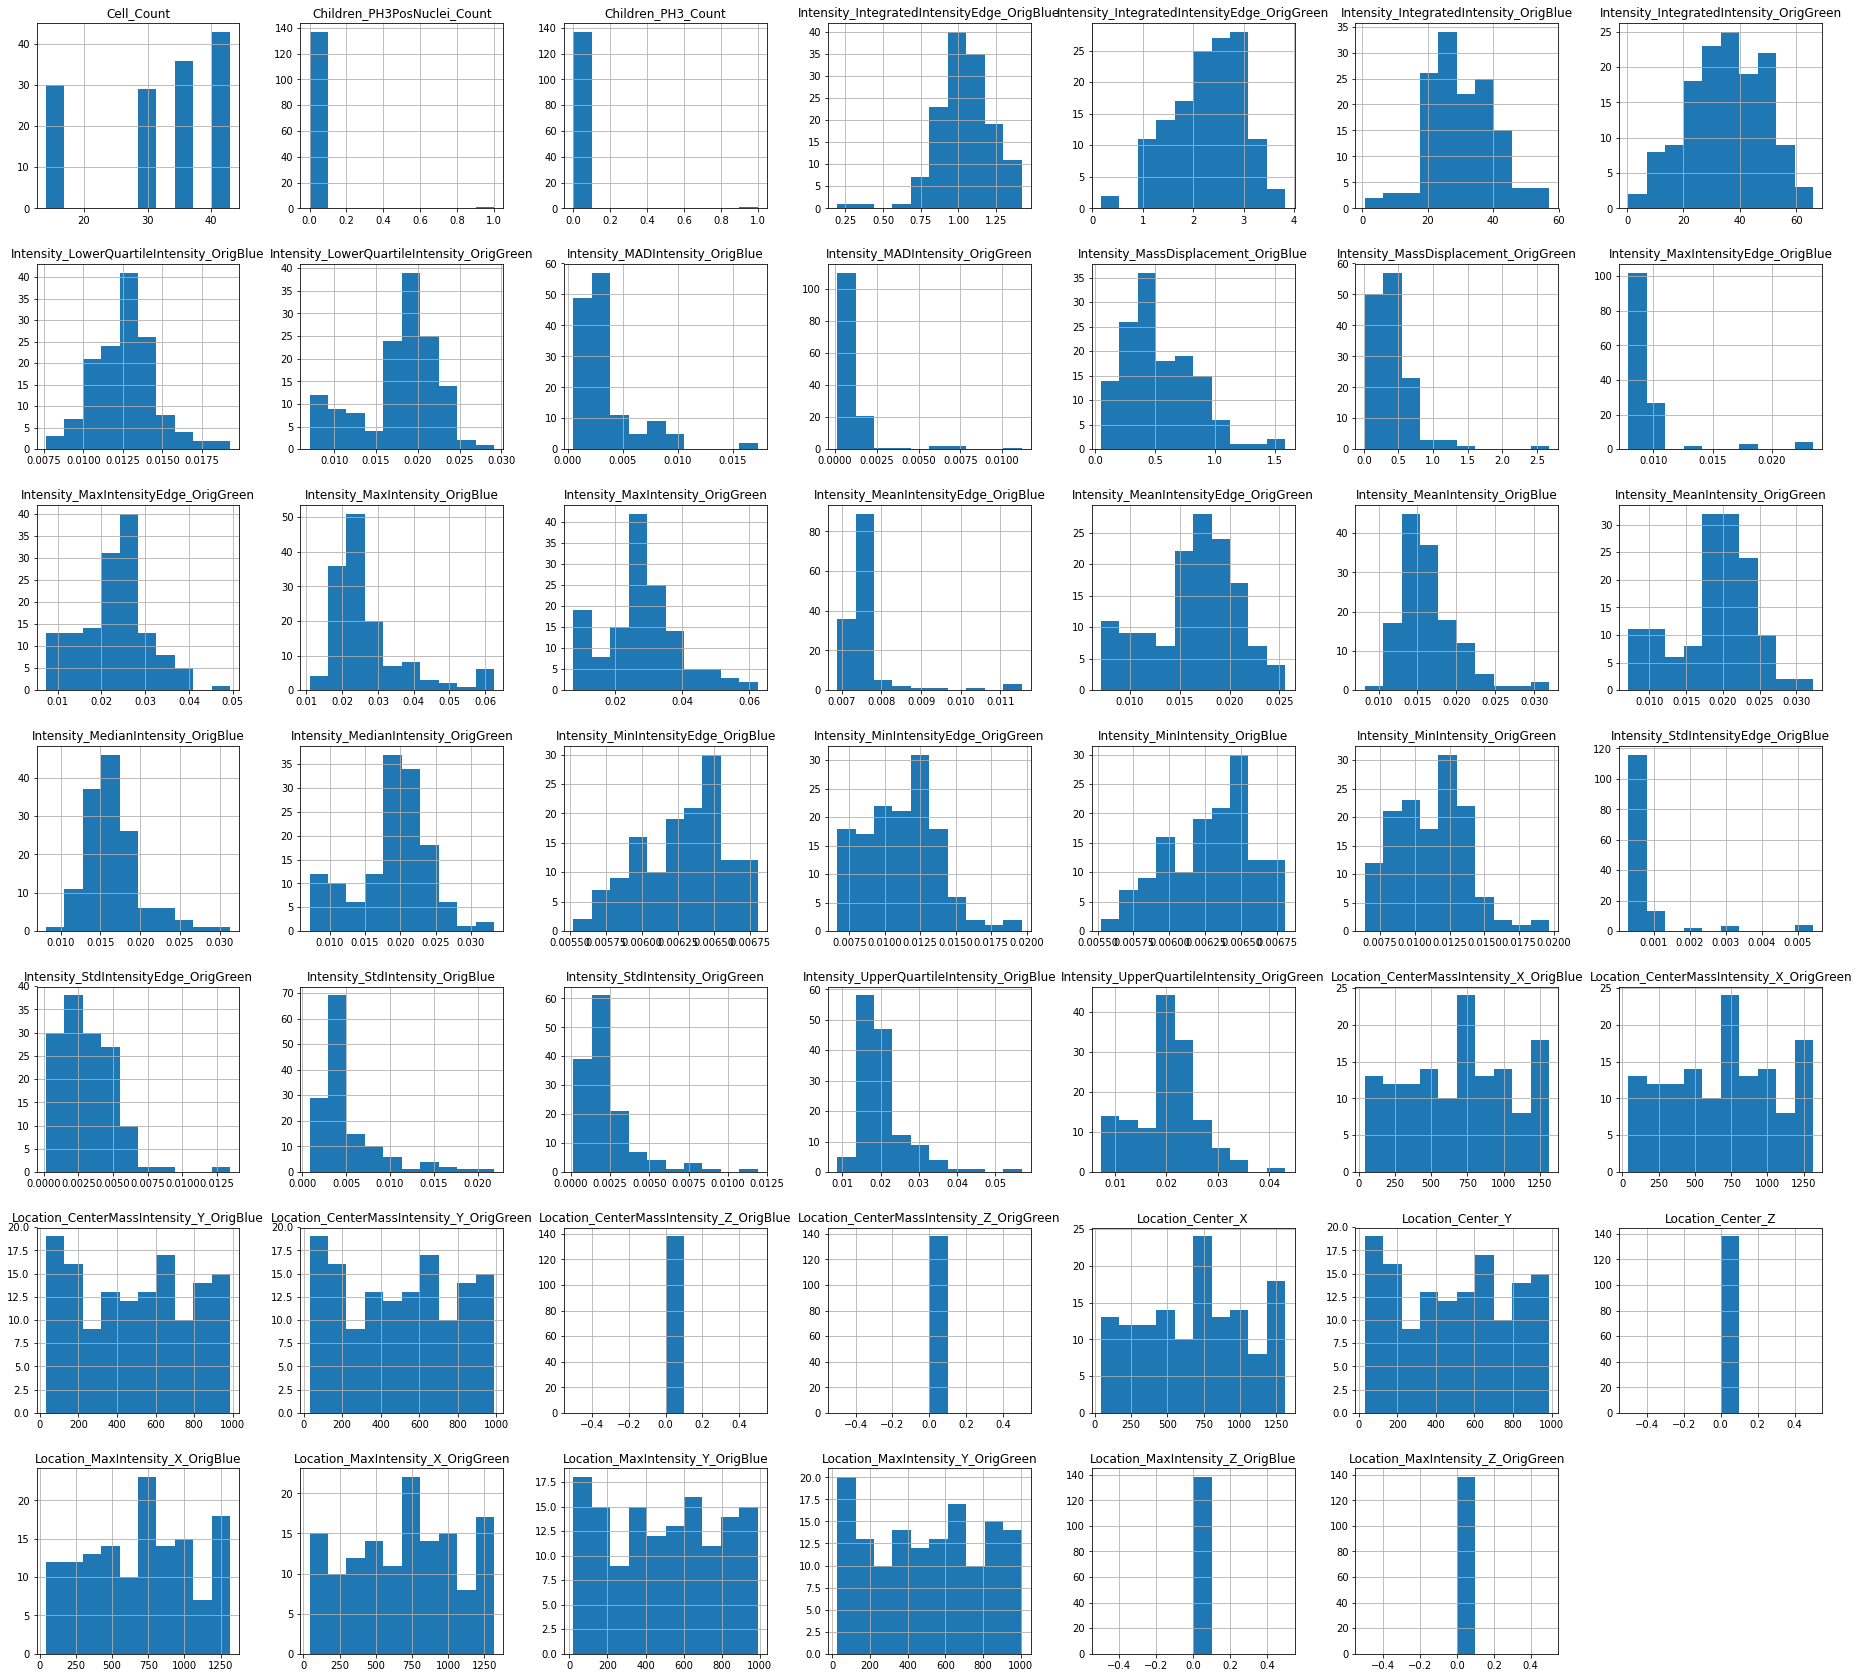

In [10]:
matplotlib.rcParams['figure.figsize'] = (32.0, 30.0)
# Drop few columns
df = Nuclei.drop(['Image', 'ImageNumber', 'Well', 'ObjectNumber', 'Number_Object_Number', 'Classify_PH3Neg', 'Classify_PH3Pos'], axis=1)
df.hist();

### Close the connection to the server

In [11]:
conn.close()